In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ada/financial_habit.csv")

In [3]:
df.tail()

,age,gender,monthly_income_range,total_monthly_spending,food_spending,transport_spending,entertainment_spending,shopping_spending,rent_spending,other_spending,...,budget_adherence,impulse_purchase_frequency,saves_monthly,amount_saved_last_month,monthly_savings_goal,saving_difficulty_score,main_saving_obstacle,income_stability,impulse_purchase_trigger,reason_for_not_saving
75,21,Мужской,300 000 – 500 000,250000,35000,10000,20000.0,75000.0,50000,10000.0,...,Да,3,Да,50000,На жилье,1,NaN,Частично (фриланс / бонусы),Unknown,Unknown
76,22,Женский,200 000 – 300 000,200000,75000,12500,50000.0,25000.0,0,50000.0,...,"Пытаюсь, но не получается придерживаться",2,Нет,0,NaN,2,"Низкий доход, Сложно контролировать расходы",Частично (фриланс / бонусы),После зарплаты,Не хватает дохода
77,22,Женский,300 000 – 500 000,300000,100000,30000,300000.0,45000.0,0,30000.0,...,"Пытаюсь, но не получается придерживаться",3,Да,0,NaN,3,Непредвиденные расходы,"Да, фиксированный",В выходные,"Трачу больше, чем планирую"
78,26,Женский,300 000 – 500 000,250000,100000,5000,20000.0,20000.0,60000,20000.0,...,Да,4,Да,250000,На жилье,3,"Непредвиденные расходы, Нет привычки вести бюджет","Да, фиксированный",После стресса,Жинаймын
79,22,Женский,300 000 – 500 000,500000,200000,150000,100000.0,50000.0,50000,100000.0,...,"Пытаюсь, но не получается придерживаться",3,Да,100000,80000,5,"Нет привычки вести бюджет, Сложно контролирова...",Частично (фриланс / бонусы),После зарплаты,Unknown


In [4]:
spending_cols = [
    "food_spending",
    "transport_spending",
    "entertainment_spending",
    "shopping_spending",
    "rent_spending",
    "other_spending"
]

df["calculated_spending"] = df[spending_cols].sum(axis=1)
df["spending_difference"] = df["total_monthly_spending"] - df["calculated_spending"]

df["spending_difference"].describe()

,spending_difference
count,80.000000
mean,-46506.250000
std,161712.757021
min,-860000.000000
25%,-130000.000000
50%,-35000.000000
75%,21250.000000
max,350000.000000


During preprocessing, a systematic discrepancy was observed between reported total spending and the sum of category-level expenses. To mitigate self-reporting bias, category-based spending aggregation was used as a more reliable estimate of actual monthly expenses.

In [5]:
df["effective_total_spending"] = df["calculated_spending"]
df["effective_total_spending"].describe()

,effective_total_spending
count,8.000000e+01
mean,4.247562e+05
std,3.820939e+05
min,3.250000e+04
25%,2.000000e+05
50%,3.600000e+05
75%,5.262500e+05
max,3.040000e+06


In [6]:
for col in spending_cols:
    df[f"{col}_share"] = df[col] / df["effective_total_spending"]

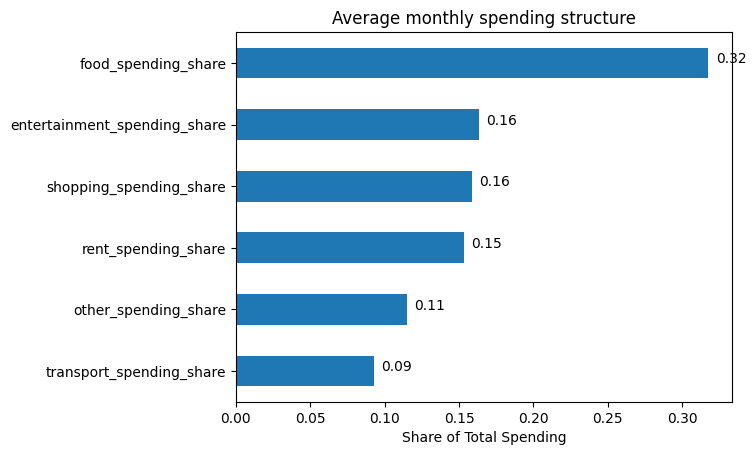

In [28]:
share_cols = [c for c in df.columns if c.endswith("_share")]

df[share_cols].mean().sort_values().plot(kind="barh")
for i, v in enumerate(df[share_cols].mean().sort_values()):
    plt.text(v + 0.005, i, f"{v:.2f}")
plt.title("Average monthly spending structure")
plt.xlabel("Share of Total Spending")
plt.show()

In [8]:
df["discretionary_spending"] = (
    df["entertainment_spending"] + df["shopping_spending"]
)

df["discretionary_ratio"] = (
    df["discretionary_spending"] / df["effective_total_spending"]
)

In [9]:
df["savings_intensity"] = (
    df["amount_saved_last_month"] / df["effective_total_spending"]
)

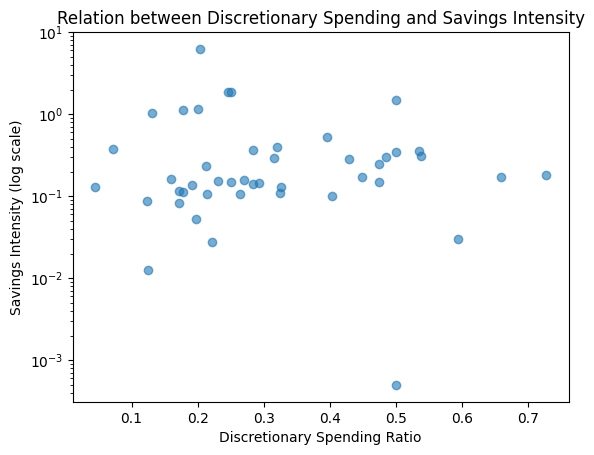

In [29]:
plt.figure()
plt.scatter(df["discretionary_ratio"], df["savings_intensity"], alpha=0.6)
plt.xlabel("Discretionary Spending Ratio")
plt.yscale("log")
plt.ylabel("Savings Intensity (log scale)")
plt.title("Relation between Discretionary Spending and Savings Intensity")
plt.show()

In [12]:
df["savings_gap_ratio"] = (df["amount_saved_last_month"] /(df["total_monthly_spending"] + 1))

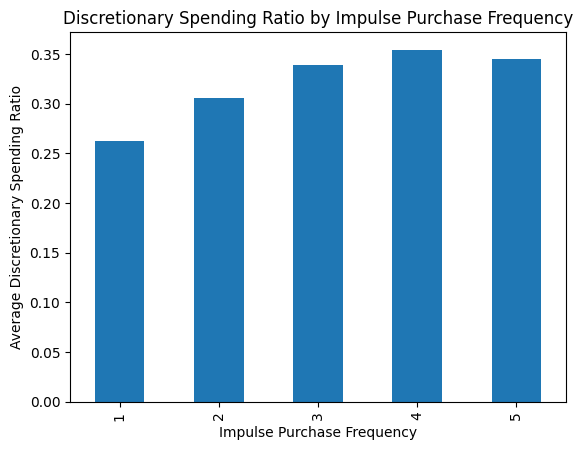

In [30]:
df.groupby("impulse_purchase_frequency")["discretionary_ratio"].mean().plot(kind="bar")
plt.title("Discretionary Spending Ratio by Impulse Purchase Frequency")
plt.xlabel("Impulse Purchase Frequency")
plt.ylabel("Average Discretionary Spending Ratio")
plt.show()

In [14]:
df.groupby("saves_monthly")["saving_difficulty_score"].mean()

,saving_difficulty_score
saves_monthly,
Да,2.574468
Нет,3.515152


In [15]:
df["reason_for_not_saving"].value_counts()

,count
reason_for_not_saving,
"Трачу больше, чем планирую",27
Не хватает дохода,23
Unknown,19
Нет чёткой цели,7
Забываю,1
Не считаю нужным,1
Жинайм жұмысайм,1
Жинаймын,1


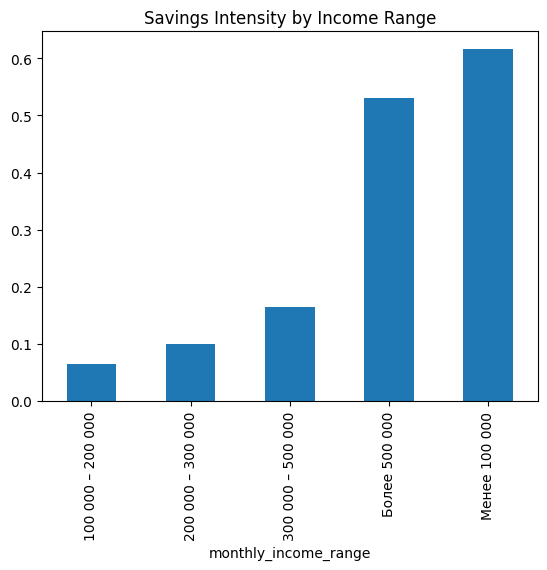

In [16]:
df.groupby("monthly_income_range")["savings_intensity"].mean().plot(kind="bar")
plt.title("Savings Intensity by Income Range")
plt.show()

In [17]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/ada/new_features_financial_habit.csv", index=False)

In [18]:
num_vars = [
    "effective_total_spending",
    "savings_intensity",
    "discretionary_ratio",
    "impulse_purchase_frequency",
    "saving_difficulty_score",
    "savings_gap_ratio"
]

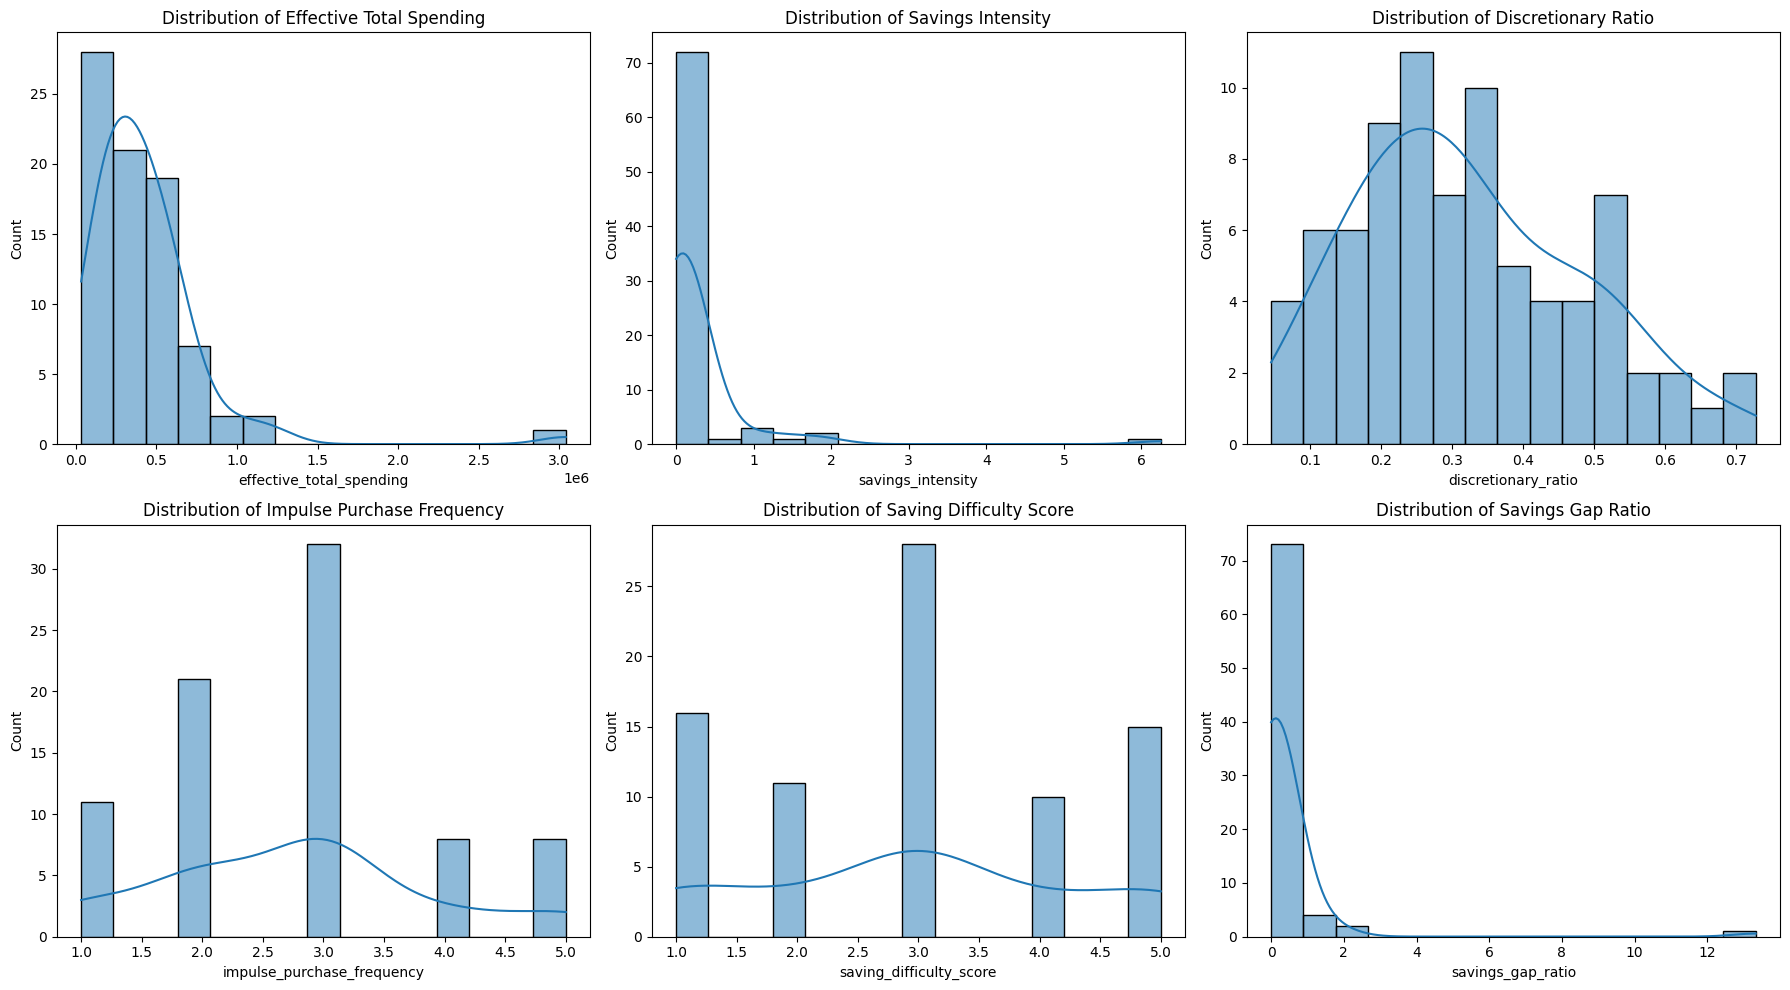

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    sns.histplot(
        df[col].dropna(),
        bins=15,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {col.replace('_', ' ').title()}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

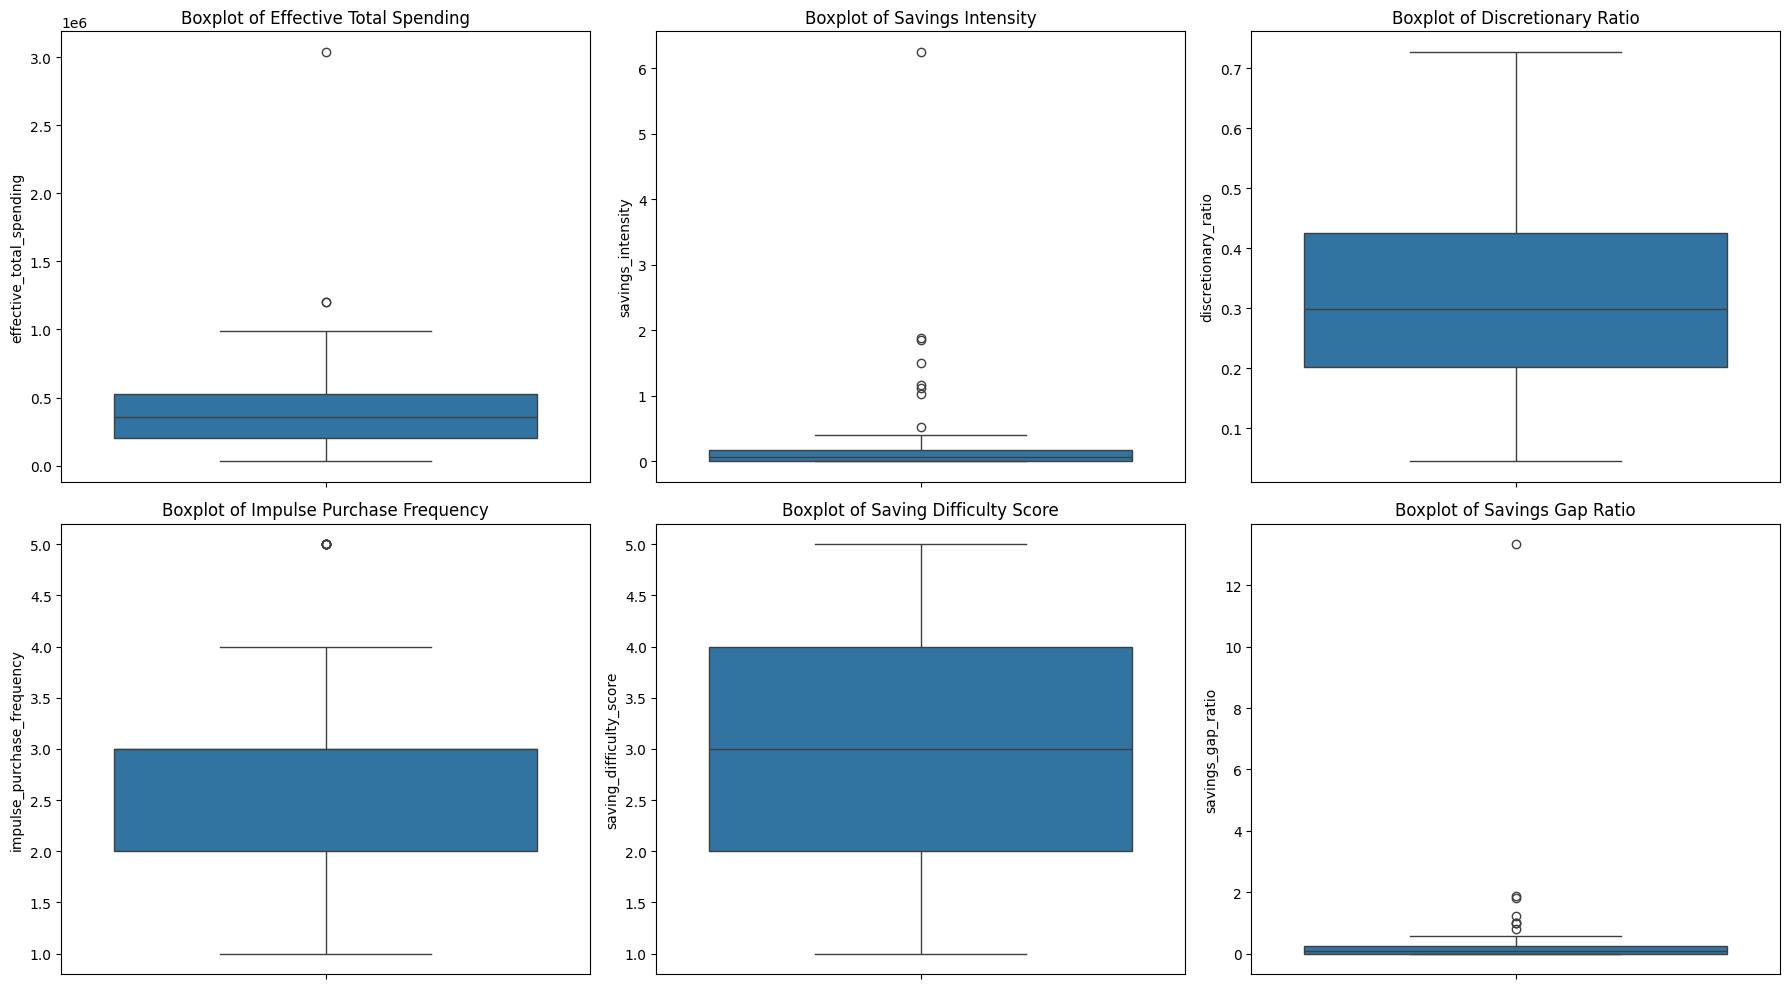

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_vars):
    sns.boxplot(
        y=df[col],
        ax=axes[i]
    )
    axes[i].set_title(f"Boxplot of {col.replace('_', ' ').title()}")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

In [21]:
cat_vars = [
    "gender",
    "monthly_income_range",
    "expense_tracking",
    "budget_adherence",
    "saves_monthly",
    "income_stability"
]

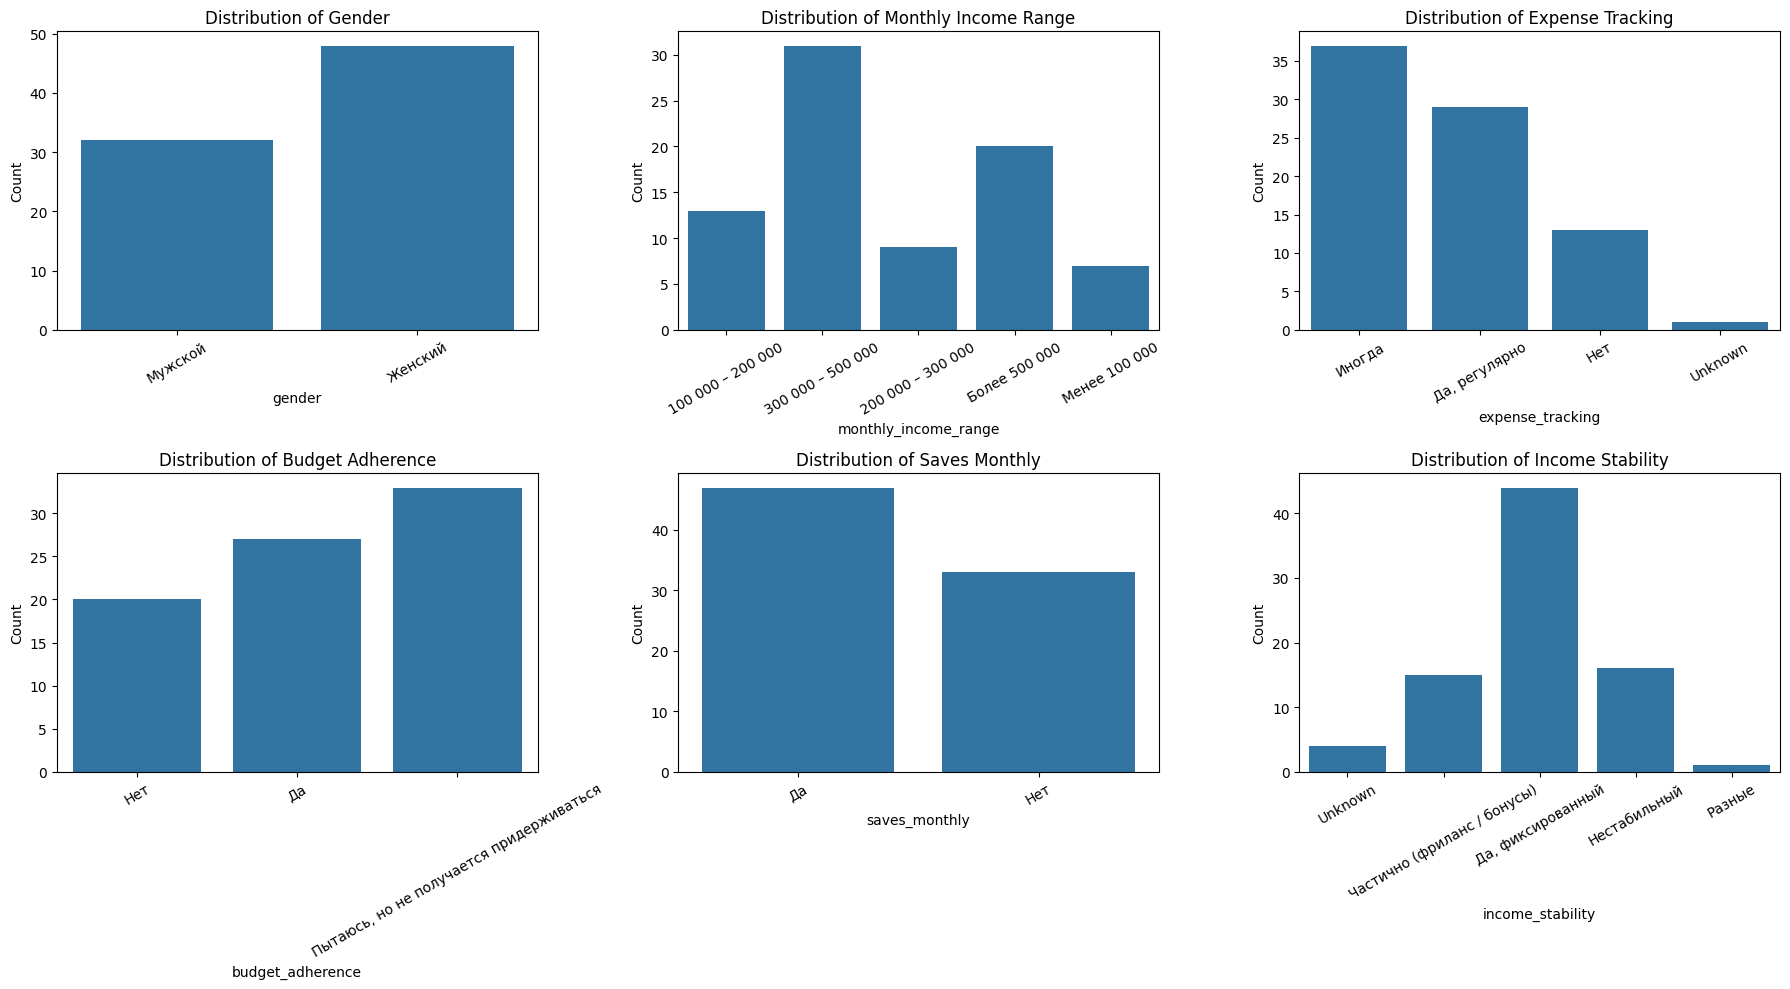

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_vars):
    sns.countplot(
        data=df,
        x=col,
        ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {col.replace('_', ' ').title()}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

In [23]:
heatmap_vars = [
    "effective_total_spending",
    "savings_intensity",
    "discretionary_ratio",
    "impulse_purchase_frequency",
    "saving_difficulty_score",
    "rent_spending_share",
    "savings_gap_ratio"
]

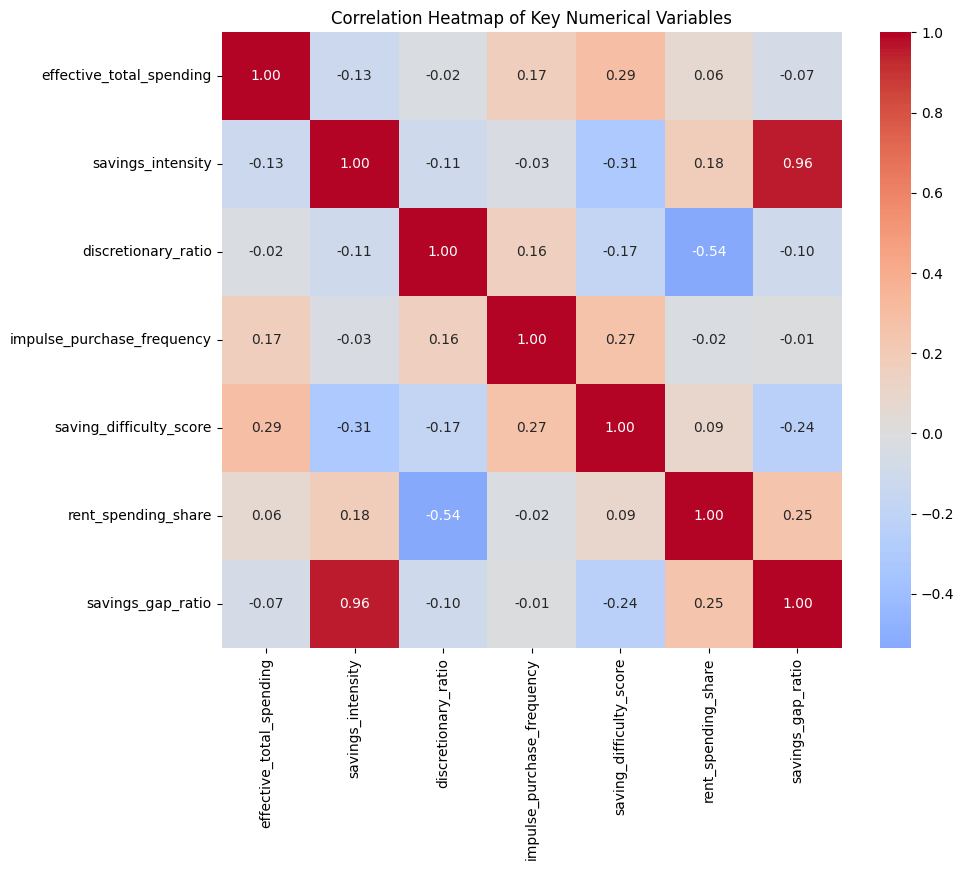

In [24]:
corr = df[heatmap_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap of Key Numerical Variables")
plt.show()

In [25]:
text_data = (
    df["monthly_savings_goal"]
    .dropna()
    .astype(str)
    .str.lower()
)

In [26]:
text = " ".join(text_data)

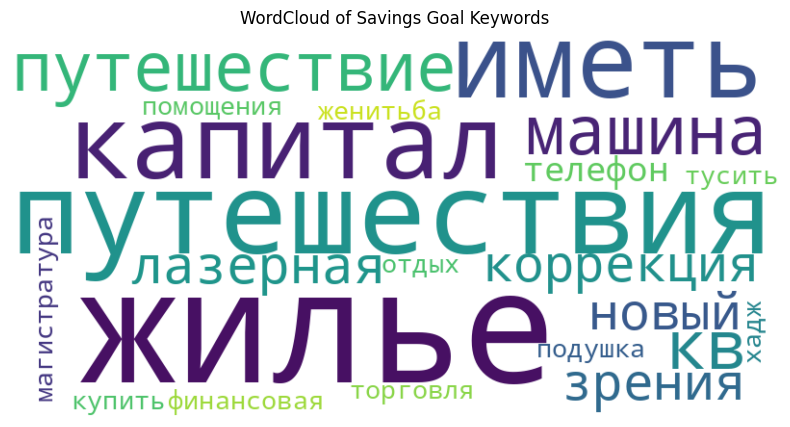

In [27]:
custom_stopwords = {
    "на", "для", "и", "в", "не", "нет", "пока",
    "цель", "ставлю", "ставить", "хочу"
}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=custom_stopwords,
    collocations=False
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Savings Goal Keywords")
plt.show()
